In [1]:
#np.where(np.isinf(x) is True)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import r2_score
data = pd.read_csv('data.csv', delimiter=',')
data.columns


Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'],
      dtype='object')

   WSPM        O3
0   1.0  2.000000
1   0.7  2.000000
2   1.1  2.000000
3   1.1  1.584963
4   1.0  4.000000


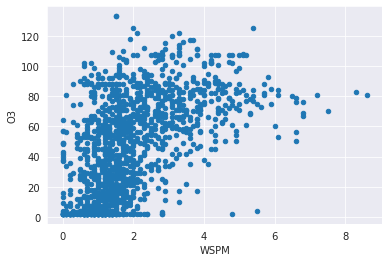

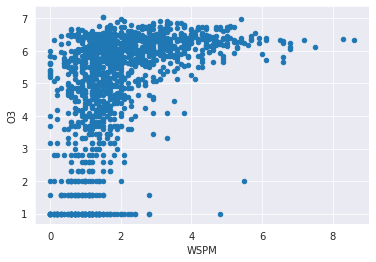

In [3]:
temp = data.loc(axis=1)['WSPM', 'O3']
temp_raw = temp.copy()
temp['O3'] = temp['O3'].map(lambda x: np.log2(x))
print(temp.head(5))
mask = temp['O3'] != 0
temp = temp[mask]
temp_raw.sort_values('WSPM').plot(x='WSPM',y='O3', kind='scatter')
temp.sort_values('WSPM').plot(x='WSPM',y='O3', kind='scatter')


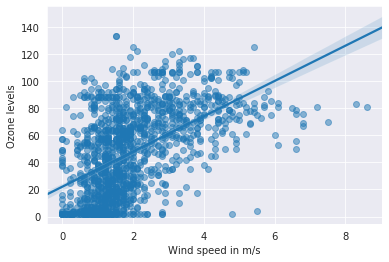

In [4]:
x = data['WSPM'].to_numpy()
x = np.reshape(x, (-1,1))
y = data['O3'].to_numpy()
ax = sns.regplot(x=x, y=y, fit_reg=True, scatter_kws={'alpha':0.5})
ax.set(xlabel='Wind speed in m/s', ylabel='Ozone levels');

In [5]:
y.shape

(1361,)

In [6]:
x.shape


(1361, 1)

In [7]:
from numpy.linalg import inv, det
from numpy import dot

# calculating the coefficient with a god given formula
beta = dot(dot(inv(dot(x.T, x)),x.T),y)
print('estimated beta (Slope of our reg line): ', beta[0])

estimated beta (Slope of our reg line):  20.805050036450396


In [8]:
# calculating the coefficient with numpys least squares impl
beta2 = np.linalg.lstsq(x, y)[0]
print('Estimated second beta: ', beta2[0])

Estimated second beta:  20.80505003645039


/home/oran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


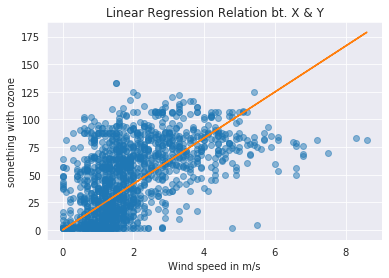

In [9]:
# this is yhat
predictions = x * beta
predictions_without_intercept = predictions
ax = sns.regplot(x=x, y=y, fit_reg=False, scatter_kws={'alpha':0.5})
ax.set(xlabel='Wind speed in m/s', 
       ylabel='something with ozone',
       title='Linear Regression Relation bt. X & Y');
plt.plot(x, predictions) # overlay a line plot over a scatter plot 
plt.show()

In [10]:
constant_term = np.ones(len(x))
x = np.c_[constant_term, x]
print(x)

[[1.  1. ]
 [1.  0.7]
 [1.  1.1]
 ...
 [1.  1.1]
 [1.  1.2]
 [1.  1.3]]


In [11]:
beta = np.linalg.lstsq(x, y)[0]
print('Estimated coefficients: ', beta)
print(x)
print('Old shape of coefficients array', beta.shape)
beta = np.reshape(beta,(-1,1))
print('new shape of coefficients array', beta.shape)

Estimated coefficients:  [22.08067686 13.00532788]
[[1.  1. ]
 [1.  0.7]
 [1.  1.1]
 ...
 [1.  1.1]
 [1.  1.2]
 [1.  1.3]]
Old shape of coefficients array (2,)
new shape of coefficients array (2, 1)


/home/oran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


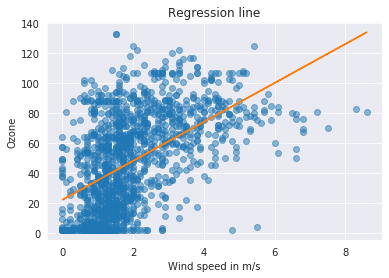

In [12]:
#compute predictions wiht intercept 
#(aka linear regression yhat=beta0+beta1*x)
predictions_with_intercept = dot(x, beta)
ax = sns.regplot(x=x[:,1], y=y, fit_reg=False, scatter_kws={'alpha':0.5})
ax.set(xlabel='Wind speed in m/s',
        ylabel='Ozone',
      title='Regression line')
plt.plot(x[:,1], predictions_with_intercept)
plt.show()

In [13]:
# r^2 = 1 - (SS_resid / SS_total)
# where SS_resid = np.sum((y-y_pred)**2) -->squared sum of differences between predicted and actual y
# SS_total = np.sum(y - ymean)**2) --> ybar aka squared sum of differences between y and mean of y
# SSR = SS_reg = np.sum(y_pred - ymean)**2) --> explained sum of squares (deviation of predictions from mean of actual values)
ss_total = np.sum((y - np.mean(y)) ** 2 ) 
ssr = np.sum((predictions_with_intercept - np.mean(y)) ** 2)
ss_resid = np.sum((predictions_with_intercept[:,0] - y) ** 2)
variance = np.var(y, ddof=1)
ss_total_variance = (len(y) - 1) * variance
# Score above 70% -- “somewhat satisfied”
r_squared = 1 - (ss_resid / ss_total)


print('SS_total: ', ss_total, ' ', ss_total_variance)
print('SSR: ', ssr)
print('SS_resid: ', ss_resid)
print('Coefficient of determinacy (aka r^2): ',r_squared)


SS_total:  1422247.2872887584   1422247.2872887584
SSR:  393435.35089371674
SS_resid:  1028811.9363950414
Coefficient of determinacy (aka r^2):  0.2766293558159819


(1361,)
(1361,)
(1361, 1)


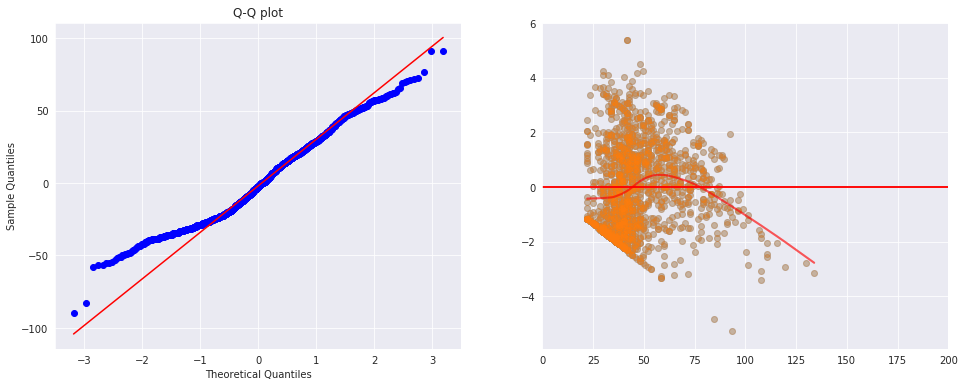

In [14]:
fig, axs = plt.subplots(ncols=2,
                         figsize=(16,6))
predictions = dot(x,beta)[:,0]
residuals = y - predictions
print(residuals.shape)
deg_of_freedom = len(y) - x.shape[1]
x_val = x[:,1]
sm.qqplot(residuals, 
          stats.t,
          distargs=(deg_of_freedom,), 
          line='q', 
          ax=axs[0])
axs[0].set_title(label = 'Q-Q plot')
axs[0].set_xlim(-3.5,3.5)

residuals_standard_error = np.sqrt(ssr / deg_of_freedom)
xmean = np.sum(x_val)/len(x_val)
leverage = (1 / len(x_val)) + (x_val - xmean) **2\
                            / np.sum((x_val-xmean) ** 2)
leverage = np.reshape(leverage,(-1,1))

s_resid = residuals_standard_error* np.sqrt(1-leverage)
standardized_residuals = residuals / s_resid[:,0]
print(standardized_residuals.shape)
print(s_resid.shape)
sns.regplot(x=predictions, 
            y=standardized_residuals, 
            ax=axs[1],
            lowess=True, 
            scatter_kws={'alpha':0.3}, 
            line_kws={"color":"r","alpha":0.4,"lw":2})
plt.plot(np.arange(len(standardized_residuals)), [0]*len(standardized_residuals), 'r-')
axs[1].set_xlim(0,200)
sns.regplot(x=predictions, 
            y=standardized_residuals, 
            ax=axs[1],
            lowess=True, 
            scatter_kws={'alpha':0.3}, 
            line_kws={"color":"r","alpha":0.4,"lw":2})
plt.plot(np.arange(len(standardized_residuals)), [0]*len(standardized_residuals), 'r-')


estimated beta (Slope of our reg line):  1.3346691143954625
Estimated second beta:  1.334669114395462


/home/oran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


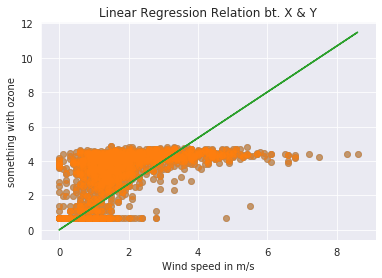

[[1.  1. ]
 [1.  0.7]
 [1.  1.1]
 ...
 [1.  1.1]
 [1.  1.2]
 [1.  1.3]]
Estimated coefficients:  [2.52616222 0.44233399]
[[1.  1. ]
 [1.  0.7]
 [1.  1.1]
 ...
 [1.  1.1]
 [1.  1.2]
 [1.  1.3]]
Old shape of coefficients array (2,)
new shape of coefficients array (2, 1)


/home/oran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


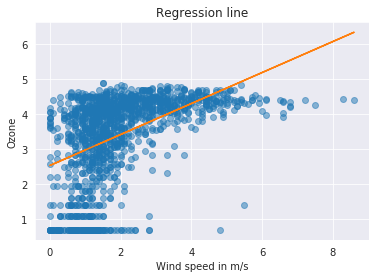

yhat  (1361, 1)
ylog (1361,)
SS_total:  2033.1590852446234   2033.1590852446234
SSR:  455.1257438400604
SS_resid:  1578.0333414045635
Coefficient of determinacy (aka r^2):  0.22385151616667542
(1361,)
(1361,)
(1361, 1)


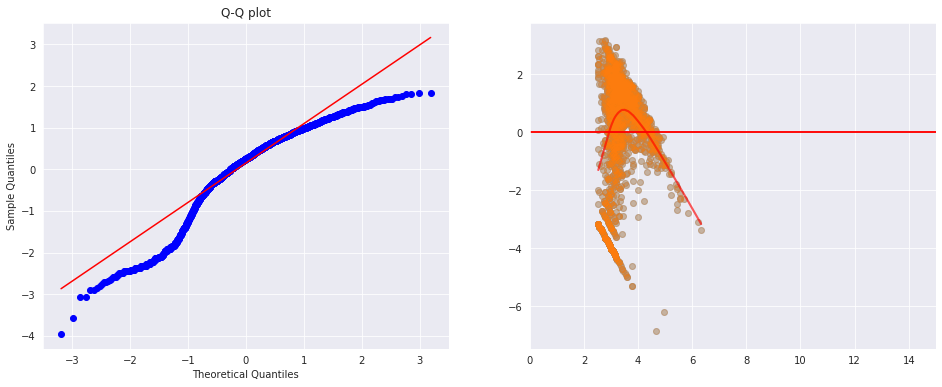

In [15]:
#                       #
#                       #
#LOGARITHMIC REGRESSION #
#                       #
#                       #
#                       #
x_log = data['WSPM'].to_numpy()
x_log = np.reshape(x_log, (-1,1))
y_log = np.log(data['O3'].to_numpy())
ax = sns.regplot(x=x_log, y=y_log, fit_reg=False, scatter_kws={'alpha':0.5})
ax.set(xlabel='Wind speed in m/s', ylabel='Ozone levels');

# calculating the coefficient with a god given formula
beta_log = dot(dot(inv(dot(x_log.T, x_log)),x_log.T),y_log)
print('estimated beta (Slope of our reg line): ', beta_log[0])

# calculating the coefficient with numpys least squares impl
beta2_log = np.linalg.lstsq(x_log, y_log)[0]
print('Estimated second beta: ', beta2_log[0])


# this is yhat
predictions_log = x_log * beta_log
predictions_without_intercept_log = predictions_log
ax = sns.regplot(x=x_log, y=y_log, fit_reg=False, scatter_kws={'alpha':0.5})
ax.set(xlabel='Wind speed in m/s', 
       ylabel='something with ozone',
       title='Linear Regression Relation bt. X & Y');
plt.plot(x_log, predictions_log) # overlay a line plot over a scatter plot 
plt.show()

constant_term = np.ones(len(x_log))
x_log = np.c_[constant_term, x_log]
print(x_log)

beta_log = np.linalg.lstsq(x_log, y_log)[0]
print('Estimated coefficients: ', beta_log)
print(x_log)
print('Old shape of coefficients array', beta_log.shape)
beta_log = np.reshape(beta_log,(-1,1))
print('new shape of coefficients array', beta_log.shape)

#compute predictions wiht intercept 
#(aka linear regression yhat=beta0+beta1*x)
predictions_with_intercept_log = dot(x_log, beta_log)
ax = sns.regplot(x=x_log[:,1], y=y_log, fit_reg=False, scatter_kws={'alpha':0.5})
ax.set(xlabel='Wind speed in m/s',
        ylabel='Ozone',
      title='Regression line')
plt.plot(x_log[:,1], predictions_with_intercept_log)
plt.show()

# r^2 = 1 - (SS_resid / SS_total)
# where SS_resid = np.sum((y-y_pred)**2) -->squared sum of differences between predicted and actual y
# SS_total = np.sum(y - ymean)**2) --> ybar aka squared sum of differences between y and mean of y
# SSR = SS_reg = np.sum(y_pred - ymean)**2) --> explained sum of squares (deviation of predictions from mean of actual values)
print('yhat ',predictions_with_intercept_log.shape)
print('ylog',y_log.shape)
ss_total_log = np.sum((y_log - np.mean(y_log)) ** 2 ) 
ssr_log = np.sum((predictions_with_intercept_log[:,0] - np.mean(y_log)) ** 2)
ss_resid_log = np.sum((predictions_with_intercept_log[:,0] - y_log) ** 2)
variance_log = np.var(y_log, ddof=1)
ss_total_variance_log = (len(y_log) - 1) * variance_log
# Score above 70% -- “somewhat satisfied”
r_squared_log = 1 - (ss_resid_log / ss_total_log)
print('SS_total: ', ss_total_log, ' ', ss_total_variance_log)
print('SSR: ', ssr_log)
print('SS_resid: ', ss_resid_log)
print('Coefficient of determinacy (aka r^2): ',r_squared_log)

fig, axs = plt.subplots(ncols=2,
                         figsize=(16,6))
predictions_log = dot(x_log,beta_log)[:,0]
residuals_log = y_log - predictions_log
print(residuals_log.shape)
deg_of_freedom_log = len(y_log) - x_log.shape[1]
x_val_log = x_log[:,1]
sm.qqplot(residuals_log, 
          stats.t,
          distargs=(deg_of_freedom_log,), 
          line='q', 
          ax=axs[0])
axs[0].set_title(label = 'Q-Q plot')
axs[0].set_xlim(-3.5,3.5)

residuals_standard_error_log = np.sqrt(ssr_log / deg_of_freedom_log)
xmean_log = np.sum(x_val_log)/len(x_val_log)
leverage_log = (1 / len(x_val_log)) + (x_val_log - xmean_log) **2\
                            / np.sum((x_val_log-xmean_log) ** 2)
leverage_log = np.reshape(leverage_log,(-1,1))

s_resid_log = residuals_standard_error_log* np.sqrt(1-leverage_log)
standardized_residuals_log = residuals_log / s_resid_log[:,0]
print(standardized_residuals_log.shape)
print(s_resid_log.shape)
sns.regplot(x=predictions_log, 
            y=standardized_residuals_log, 
            ax=axs[1],
            lowess=True, 
            scatter_kws={'alpha':0.3}, 
            line_kws={"color":"r","alpha":0.4,"lw":2})
plt.plot(np.arange(len(standardized_residuals_log)), [0]*len(standardized_residuals_log), 'r-')
axs[1].set_xlim(0,15)
sns.regplot(x=predictions_log, 
            y=standardized_residuals_log, 
            ax=axs[1],
            lowess=True, 
            scatter_kws={'alpha':0.3}, 
            line_kws={"color":"r","alpha":0.4,"lw":2})
plt.plot(np.arange(len(standardized_residuals_log)), [0]*len(standardized_residuals_log), 'r-')



In [16]:
print('ŷ = {}x + {}'.format(float(beta_log[0]), float(beta_log[1])))


ŷ = 2.5261622200063836x + 0.4423339939345954


In [17]:
import numpy.ma as ma
print(y_log.shape)
print(x_log[:,1].shape)
corr = np.ma.corrcoef(y_log, x_log[:,1])

print('Correlation:', corr[0,1], '\nDeterminacy: ', r_squared_log, '\nrroot:',np.sqrt(r_squared_log))

(1361,)
(1361,)
Correlation: 0.4731294919645947 
Determinacy:  0.22385151616667542 
rroot: 0.47312949196459464


In [35]:
#
#TESTING NULL HYPOTHESIS
#
sigma_degrees_of_freedom = len(x_log) - 2
sigma_sqr = ssr_log / (deg_of_freedom_log -1)
variance_covmatrix = np.cov(x_log[:,1],y_log)
coeff_stde = np.sqrt(ssr_log / sigma_degrees_of_freedom * 1)
print(variance_covmatrix)
print(ssr_log)  

[[1.71037705 0.75655791]
 [0.75655791 1.49496992]]
455.1257438400604
